# Dimensionality Reduction Techniques: The Good, The Bad, The Ugly

In this notebook, we will explore some of the most famous and widely used dimensionality reduction techniques: **PCA (Principal Component Analysis)**, **MDS (MultiDimensional Scaling)**, **t-SNE (t-Distributed Stochastic Neighbor Embedding)**, and **UMAP (Uniform Manifold Approximation and Projection)**.

# Digits

Setting up the code for the experiments

In [4]:
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
n_neighbors = 30

Text(0.5, 0.98, 'A selection from the 64-dimensional digits dataset')

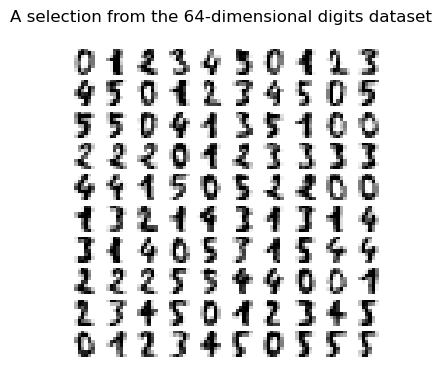

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(4, 4))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")

fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=12)

In [6]:
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D  # For custom legend markers


def plot_embedding(X, title, ax, legend=False, show_axis=False, min_dist=5e-2):
    if not show_axis:
        X = MinMaxScaler().fit_transform(X)

    # Plot each digit with its corresponding marker
    for digit in np.unique(y):
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=1,
        )

    shown_images = np.array([[np.inf, np.inf]])  # Just something big
    for i in range(X.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < min_dist:
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=2)
        ax.add_artist(imagebox)

    ax.set_title(title)
    if not show_axis:
        ax.axis("off")

    # Custom legend with only markers
    if legend:
        legend_elements = [
            Line2D(
                [0],
                [0],
                marker=f"${digit}$",
                color=plt.cm.Dark2(digit),
                markerfacecolor=plt.cm.Dark2(digit),
                markersize=10,
            )
            for digit in np.unique(y)
        ]
        ax.legend(
            legend_elements, [""] * len(legend_elements), loc="best", title="Digits"
        )

In [ ]:
import umap

from sklearn.decomposition import PCA

from sklearn.manifold import (
    MDS,
    Isomap,
    TSNE,
)
from sklearn.pipeline import Pipeline

embeddings = {
    "PCA embedding": PCA(n_components=2),
    "MDS embedding": MDS(
        n_components=2, n_init=1, max_iter=120, n_jobs=2, normalized_stress="auto"
    ),
    "t-SNE embedding": TSNE(
        n_components=2,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=42,
    ),
    "UMAP embedding": umap.UMAP(n_components=2, random_state=42),
}

In [5]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(X, y)
    timing[name] = time() - start_time

Computing PCA embedding...
Computing MDS embedding...
Computing t-SNE embedding...
Computing UMAP embedding...


/Users/dgurnari/opt/anaconda3/envs/tda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


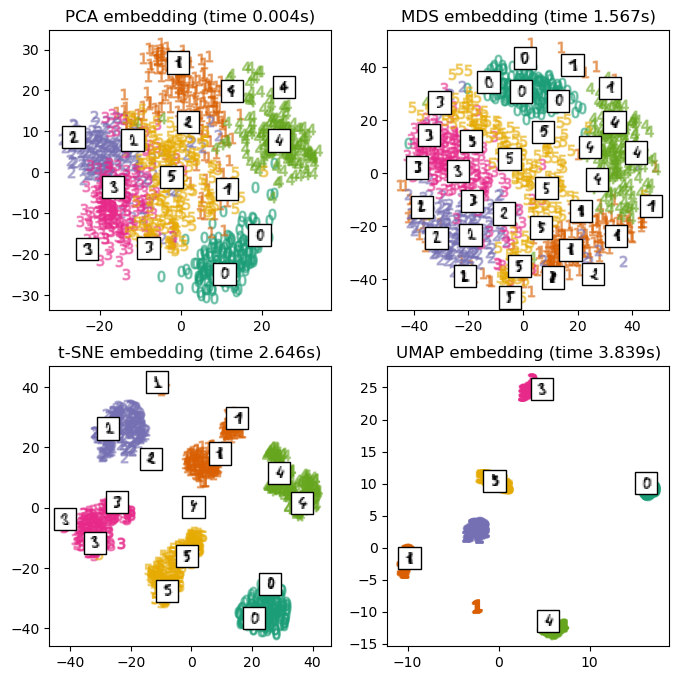

In [6]:
fig_ALL, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

coords = {"PCA embedding": (0,0),
    "MDS embedding": (0,1),
    "t-SNE embedding": (1,0),
    "UMAP embedding": (1,1)
         }

for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title, axs[*coords[name]], show_axis=True, min_dist=150)

plt.show()

# Principal Component Analysis

PCA is a **linear** dimensionality reduction technique that finds the axes (aka "principal components") along which the variance in the data is maximized. 

It then projects data onto these principal components to reduce dimensionality while retaining as much of the original variability as possible.

<!-- ### Key Features of PCA:
- **Linear**: PCA assumes linear relationships between variables.
- **Variance Maximization**: It selects directions that capture maximum variance.
- **Unsupervised**: No need for class labels in the data.

PCA works well for reducing dimensionality but may struggle with complex, non-linear data structures. -->

<img src="img/PCA.png" alt="drawing" width="550" align="center"/>

Let $\mathbf X$ be a $n \times p$ (centered) data matrix. 

The covariance matrix is given by $\mathbf C = \mathbf X^\top \mathbf X/(n-1)$.  
It is a symmetric matrix and so it can be diagonalized: $$\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$$ where $\mathbf V$ is a matrix of eigenvectors (each column is an eigenvector) and $\mathbf L$ is a diagonal matrix with eigenvalues $\lambda_i$ in the decreasing order on the diagonal. 


The eigenvectors are called *principal axes* or *principal directions* of the data.  

The $j$-th principal component is given by $j$-th column of $\mathbf {XV}$. The coordinates of the $i$-th data point in the new PC space are given by the $i$-th row of $\mathbf{XV}$.

## SVD and PCA

The singular value decomposition (SVD) of $\mathbf X$ is 

$$\mathbf X = \mathbf U \mathbf S \mathbf V^\top$$ 

where $\mathbf U$ is a unitary matrix (with columns called left singular vectors), $\mathbf S$ is the diagonal matrix of singular values $s_i$ and $\mathbf V$ columns are called right singular vectors. 

Therefore 
$$\mathbf C = \mathbf V \mathbf S \mathbf U^\top \mathbf U \mathbf S \mathbf V^\top /(n-1) = \mathbf V \frac{\mathbf S^2}{n-1}\mathbf V^\top,$$ 
right singular vectors $\mathbf V$ are principal directions (eigenvectors) and that singular values are related to the eigenvalues of covariance matrix via $\lambda_i = s_i^2/(n-1)$. 

Principal components are given by $\mathbf X \mathbf V = \mathbf U \mathbf S \mathbf V^\top \mathbf V = \mathbf U \mathbf S$.

## Example: Digits

In [7]:
%%capture

fig_digits, axs = plt.subplots(nrows=10, ncols=10, figsize=(4, 4))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")

fig_digits.suptitle("A selection from the 64-dimensional digits dataset", fontsize=12)
plt.show()

(1083, 64)


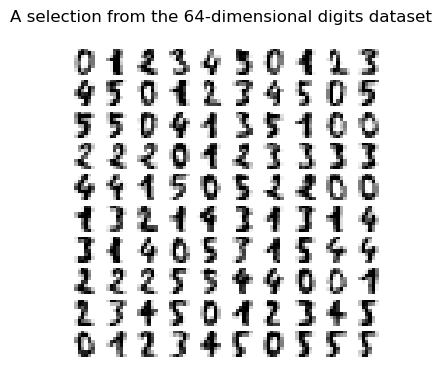

In [8]:
print(X.shape)
fig_digits

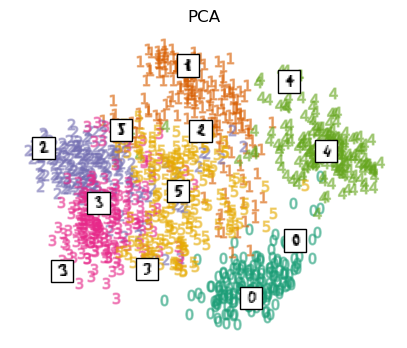

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_embedding(PCA(n_components=2).fit_transform(X, y), "PCA", ax)

# Multidimensional Scaling

MDS is an **unsupervised** technique used for dimensionality reduction and visualization. It aims to preserve the pairwise distances between data points as much as possible when mapping the data from a high-dimensional space to a lower-dimensional space.

Given a dataset $\{ x_1, x_2, ..., x_N \}$ in $\mathbb{R}^d$, we look for points $\{z_1, z_2, ..., z_N \}$ in $\mathbb{R}^k$, with $k < d$
that minimize the *stress function*

$$
S(z_1, z_2, ..., z_N) = \sum_{i \neq j} (d_{ij} - ||z_i - z_j||^2 ) .
$$

This can by achieved via **gradient descent** methods or **SMACOF** (Scaling by Majorizing a Complicated Function).



## Local MDS

Classic MDS can group together points that are geodesically distant.

We can try to fix this by modifying the stress function

$$
S_L(z_1, z_2, ..., z_N) = \sum_{(i,j) \in \mathcal{N}} (d_{ij} - ||z_i - z_j||^2 )  - \tau \sum_{(i,j) \notin \mathcal{N}} ||z_i - z_j||
$$

where $\mathcal{N}$ is the symmetric set of nearby pairs of points and $\tau$ is a tuning parameter.

<img src="img/MDS.png" alt="drawing" width="550" align="center"/>

## Isomap
Another possible solution is to try estimating the **geodesic distance** between points.

1. Determine the neighbors of each point, via fixed radius or k-NN.

2. Construct a neighborhood graph.
 
3. Compute the shortest path between each pair of nodes

4. Compute the lower-dimensional embedding via MDS.

In [ ]:
embeddings = {
    "MDS": MDS(n_components=2, random_state=42, normalized_stress="auto"),
    "Isomap": Isomap(n_components=2, n_neighbors=15),
}

from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(X, y)
    timing[name] = time() - start_time

Computing MDS...
Computing Isomap...


In [11]:
%%capture
fig_MDS, axs = plt.subplots(ncols=2, figsize=(10,5))

coords = {
    "MDS": 0,
    "Isomap": 1
         }

for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title, axs[coords[name]])

plt.show()

## Example Digits

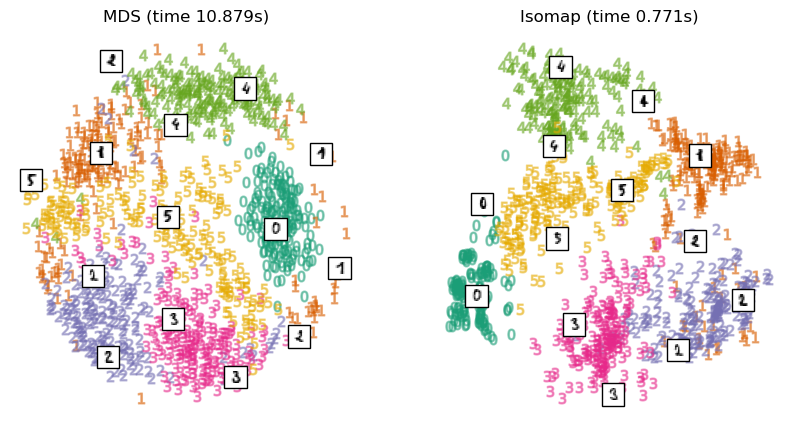

In [12]:
fig_MDS

# t-Distributed Stochastic Neighbor Embedding

t-SNE minimizes the divergence between probability distributions that represent pairwise similarities in high-dimensional and low-dimensional spaces.

### 1. Compute Pairwise Similarities in High-Dimensional Space
For each point $x_i$, the probability that $x_j$ is a neighbor of $x_i$

$$
p_{j|i} = \frac{\exp(-\|x_i - x_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\|x_i - x_k\|^2 / 2\sigma_i^2)}
$$

The variance $\sigma_i$ is adapted to the density of the data: smaller values of $\sigma _{i}$ are used in denser regions.



The joint probability $p_{ij}$ is then computed as:

$$
p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}
$$

### 2. Compute Pairwise Similarities in Low-Dimensional Space
In the low-dimensional space, the similarity between pair of points is defined via a **Student’s t-distribution** with one degree of freedom:

$$
q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
$$

The t-distribution has **heavier tails** than a Gaussian. Less similar pairs are penalized less heavily on the lower-dimensional embedding.

### 3. Minimize the Kullback-Leibler Divergence
t-SNE minimizes the difference between the high-dimensional probability distribution $p_{ij}$ and the low-dimensional distribution $q_{ij}$ using **Kullback-Leibler (KL) divergence**:

$$
C = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

## Hyperparameters
The $\sigma_i$ are directly related to **perplexity**, which controls how many "neighbors" each point considers when measuring similarity.  

The relationship between $\sigma_i$ and perplexity is established through an iterative process to find the right $\sigma_i$ for each data point that matches the target perplexity.

### What is Perplexity?
Perplexity can be thought of as a **smooth measure of the number of nearest neighbors** considered for each point. It balances between **local structure** (small perplexity) and **global structure** (large perplexity).

The perplexity is defined as:

$$
\text{Perplexity} = 2^{H(P_i)}
$$

Where $ H(P_i) $ is the **Shannon entropy** of the conditional probability distribution $P_i$:

$$
H(P_i) = - \sum_j p_{j|i} \log_2 p_{j|i}
$$

### Relationship between $\sigma_i$ and Perplexity:
For each data point $x_i$, t-SNE searches for the value of $\sigma_i$ that makes the entropy $H(P_i)$ approximately equal to the log of the target perplexity:

$$
H(P_i) \approx \log_2(\text{Perplexity})
$$

Thus, the correct $\sigma_i$ ensures that the conditional probability distribution $p_{j|i}$ has the desired "spread" of neighbors to match the perplexity.

- **Small $\sigma_i$** → Distribution is very narrow → Few neighbors have high probability (low perplexity).

- **Large $\sigma_i$** → Distribution is broad → Many neighbors have similar probabilities (high perplexity).

### How t-SNE Finds $\sigma_i$:
t-SNE uses **binary search** on $\sigma_i$ for each data point $x_i$ to ensure the perplexity matches the target value:
1. Compute the conditional probabilities $p_{j|i}$ for an initial $\sigma_i$.
2. Calculate the entropy $H(P_i)$.
3. Adjust $\sigma_i$ using binary search until $H(P_i) \approx \log_2(\text{Perplexity})$.

In [ ]:
embeddings = {
    "t-SNE p=1": TSNE(n_components=2, n_jobs=2, random_state=42, perplexity=1),
    "t-SNE p=25": TSNE(n_components=2, n_jobs=2, random_state=42, perplexity=25),
    "t-SNE p=50": TSNE(n_components=2, n_jobs=2, random_state=42, perplexity=50),
    "t-SNE p=10": TSNE(n_components=2, n_jobs=2, random_state=42, perplexity=10),
}

from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(X, y)
    timing[name] = time() - start_time

Computing t-SNE p=1...
Computing t-SNE p=25...
Computing t-SNE p=50...
Computing t-SNE p=10...


In [14]:
%%capture
fig_tSNE, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,8))

coords = {
    "t-SNE p=1": (0, 0),
    "t-SNE p=10": (0, 1),
    "t-SNE p=25": (1, 0),
    "t-SNE p=50": (1, 1),
         }

for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title, axs[*coords[name]])

plt.show()

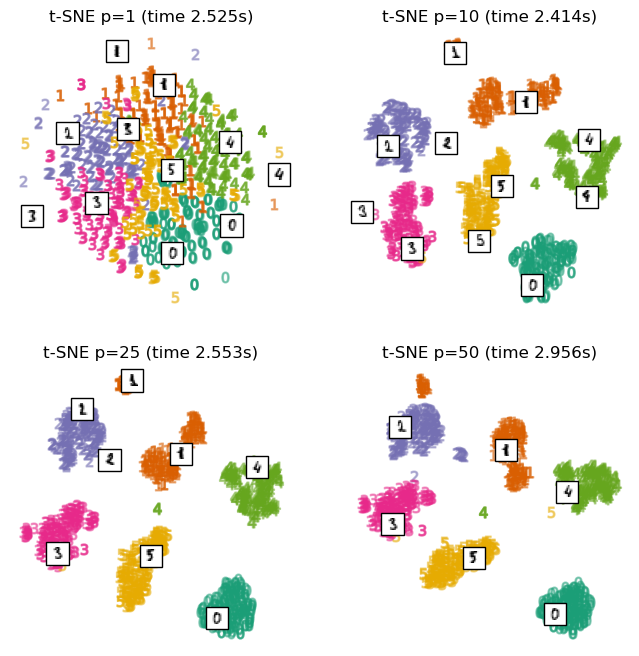

In [15]:
fig_tSNE

A nice interactive demonstration of t-SNE   
https://distill.pub/2016/misread-tsne/

## Uniform Manifold Approximation and Projection

UMAP can be used similarly to t-SNE but it claims to capture more of the global structure with superior run time performance.   

The algorithm is founded on three assumptions about the data:
1. The data is uniformly distributed on a Riemannian manifold;
2. The Riemannian metric is locally constant (or can be approximated as such);
3. The manifold is locally connected.



### Graph Construction in High-Dimensional Space

UMAP first builds a weighted graph in the high-dimensional space:

1. **k-Nearest Neighbors:**  
   For each data point $ x_i $, UMAP finds its $ k $-nearest neighbors $ \{x_j\} $ using a chosen distance metric.

<img src="img/how_umap_works_umap_open_cover.png" alt="drawing" width="550" align="center"/>  

The unit ball centered around each point is given by it's k-NN.

2. **Fuzzy Graph Representation:**  
   Instead of using fixed edges between points, UMAP uses a **fuzzy set** to represent local relationships.

   The edge weight $ w_{ij} $ between two points $ x_i $ and $ x_j $ is given by:

   $$
   w_{ij} = \exp\left(-\frac{\max(0, d(x_i, x_j) - \rho_i)}{\sigma_i}\right)
   $$
   Where:
   - $ d(x_i, x_j) $ is the distance between points $ x_i $ and $ x_j $.
   - $ \rho_i $ is the **distance to the nearest neighbor** of $ x_i $, ensuring no zero distances dominate.
   - $ \sigma_i $ controls the local scaling and is chosen to balance the neighborhood size.

<img src="img/how_umap_works_umap_graph.png" alt="drawing" width="550" align="center"/>

### Optimization in Low-Dimensional Space

In the low-dimensional space, the probability $q_{ij}$ of two points $ y_i $ and $ y_j $ being close is modeled using a Student’s t-distribution.

UMAP tries to minimize the difference between the fuzzy graph in high-dimensional space and the corresponding fuzzy graph in low-dimensional space by minimizingthe following **cross-entropy loss**:

$$
   C = \sum_{i \neq j} w_{ij} \log \left( \frac{w_{ij}}{q_{ij}} \right) + (1 - w_{ij}) \log \left( \frac{1 - w_{ij}}{1 - q_{ij}} \right)
$$


### Hyperparameters

**n_neighbors:** Controls the size of the local neighborhood used for graph construction.  
   - Low values → Focuses on fine detail (local structure).  
   - High values → Focuses on broader patterns (global structure).

**min_dist:** Controls how tightly UMAP packs points together.  
   - Low values → Clusters are tighter.  
   - High values → Clusters are more spread out.

In [ ]:
embeddings = {
    "UMAP nn=10\n min_dist=0.1": umap.UMAP(
        n_components=2, random_state=42, n_neighbors=10, min_dist=0.1
    ),
    "UMAP nn=100\n min_dist=0.1": umap.UMAP(
        n_components=2, random_state=42, n_neighbors=100, min_dist=0.1
    ),
    "UMAP nn=10\n min_dist=0.9": umap.UMAP(
        n_components=2, random_state=42, n_neighbors=10, min_dist=0.9
    ),
    "UMAP nn=100\n min_dist=0.9": umap.UMAP(
        n_components=2, random_state=42, n_neighbors=100, min_dist=0.9
    ),
}

from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(X, y)
    timing[name] = time() - start_time

Computing UMAP nn=10
 min_dist=0.1...


/Users/dgurnari/opt/anaconda3/envs/tda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP nn=100
 min_dist=0.1...


/Users/dgurnari/opt/anaconda3/envs/tda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP nn=10
 min_dist=0.9...


/Users/dgurnari/opt/anaconda3/envs/tda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP nn=100
 min_dist=0.9...


/Users/dgurnari/opt/anaconda3/envs/tda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:
%%capture
fig_UMAP, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,8))

coords = {
    "UMAP nn=10\n min_dist=0.1": (0, 0),
    "UMAP nn=100\n min_dist=0.1": (0, 1),
    "UMAP nn=10\n min_dist=0.9": (1, 0),
    "UMAP nn=100\n min_dist=0.9": (1, 1),
         }

for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title, axs[*coords[name]])

plt.show()

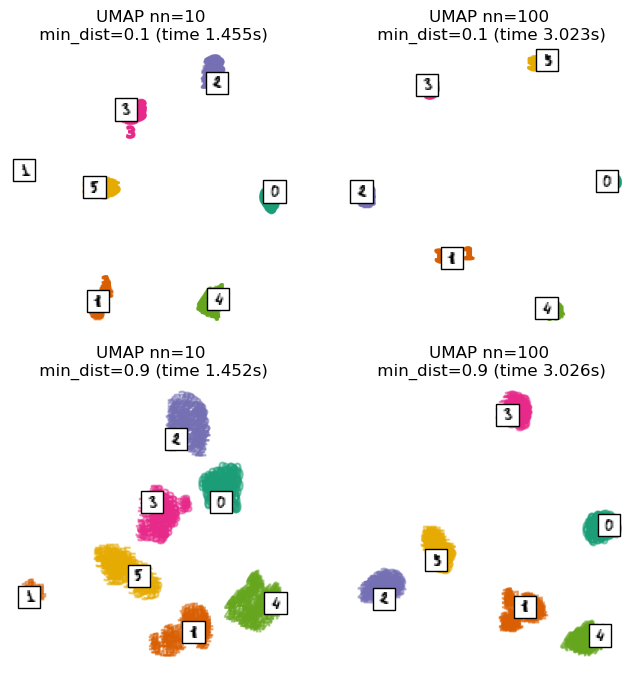

In [18]:
fig_UMAP

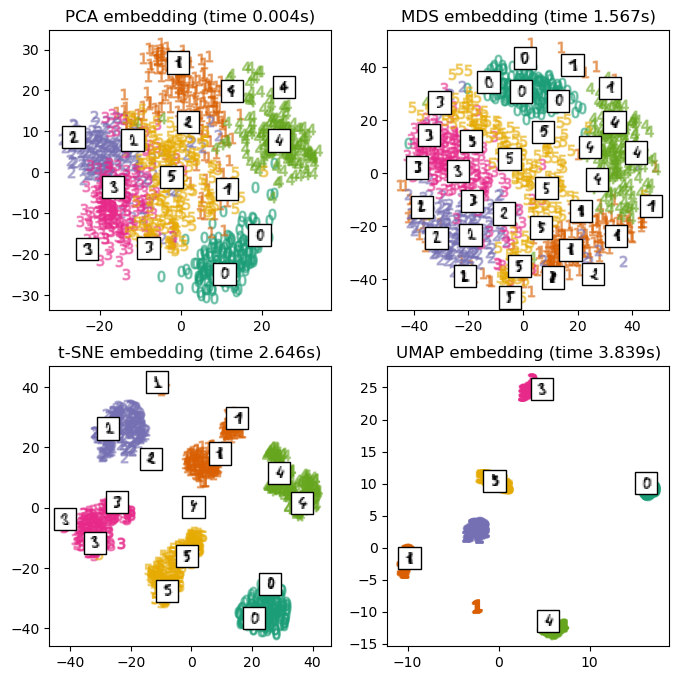

In [19]:
fig_ALL

### Things to be aware of

1. Those hyperparameters really matter

2. Cluster sizes mean nothing

3. Distances between clusters might not mean anything

4. Random noise doesn’t always look random.

# Thanks for the attention!!
<img src="img/DK9b.gif" alt="drawing" width="550" align="center"/>

                                                           ≽^•⩊•^≼

# Bonus - Single cell data

In this section we used a reduced version (20%) of the EB dataset, publically available as `scRNAseq.zip` at Mendelay Datasets at <https://data.mendeley.com/datasets/v6n743h5ng/>.   

This dataset represents a 31,000 cell 27-day time course of embryoid body (EB) differentiation.

The details on the data preprocessings can be found in the PHATE tutorial https://colab.research.google.com/github/KrishnaswamyLab/PHATE/blob/master/Python/tutorial/EmbryoidBody.ipynb. 


In [9]:
import numpy as np
import pandas as pd

from tqdm.auto import tqdm

In [12]:
EBT_counts = pd.read_pickle("data/processed_counts.pkl")
EBT_counts

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A4GALT (ENSG00000128274),AAAS (ENSG00000094914),AACS (ENSG00000081760),AADAT (ENSG00000109576),AAED1 (ENSG00000158122),...,ZWILCH (ENSG00000174442),ZWINT (ENSG00000122952),ZXDA (ENSG00000198205),ZXDB (ENSG00000198455),ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549)
AAACCGTGCAGAAA-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGATCTTGGTTG-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,1.162791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGTTTGGACGAG-1_Day 00-03,1.150109,0.0,0.0,0.000000,0.0,0.0,1.150109,0.000000,0.0,0.000000,...,0.0,1.150109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAATCCCTAGATGA-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,1.665973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAATGGGATAGCCA-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.149349,...,0.0,1.149349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTAGCTGCTAGAC-1_Day 24-27,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTATCCTAGATCC-1_Day 24-27,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCCAGAGGTGGA-1_Day 24-27,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCGAACTGAGAA-1_Day 24-27,2.197404,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
sample_labels = pd.read_pickle("data/sample_labels.pkl")
sample_labels

AAACCGTGCAGAAA-1_Day 00-03    Day 00-03
AAAGATCTTGGTTG-1_Day 00-03    Day 00-03
AAAGTTTGGACGAG-1_Day 00-03    Day 00-03
AAATCCCTAGATGA-1_Day 00-03    Day 00-03
AAATGGGATAGCCA-1_Day 00-03    Day 00-03
                                ...    
TTTAGCTGCTAGAC-1_Day 24-27    Day 24-27
TTTATCCTAGATCC-1_Day 24-27    Day 24-27
TTTCCAGAGGTGGA-1_Day 24-27    Day 24-27
TTTCGAACTGAGAA-1_Day 24-27    Day 24-27
TTTGCATGTTCTTG-1_Day 24-27    Day 24-27
Name: sample_labels, Length: 3365, dtype: object

In [35]:
X = EBT_counts.to_numpy()
y = sample_labels.to_numpy()
print(X.shape, y.shape)

(3365, 17845) (3365,)


In [ ]:
import umap

from sklearn.decomposition import PCA

from sklearn.manifold import (
    MDS,
    Isomap,
    TSNE,
)
from sklearn.pipeline import Pipeline

embeddings = {
    "PCA embedding": PCA(n_components=2),
    "MDS embedding": MDS(
        n_components=2, n_init=1, max_iter=120, n_jobs=2, normalized_stress="auto"
    ),
    "t-SNE embedding": Pipeline(
        [
            ("pca", PCA(n_components=100)),  # Reduce to 100 dimensions with PCA
            (
                "tsne",
                TSNE(n_components=2, random_state=42),
            ),  # Further reduce to 2 dimensions with t-SNE
        ]
    ),
    "UMAP embedding": umap.UMAP(n_components=2, random_state=42),
}

In [53]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(X)
    timing[name] = time() - start_time

Computing PCA embedding...
Computing MDS embedding...
Computing t-SNE embedding...
Computing UMAP embedding...


In [54]:
import seaborn as sns

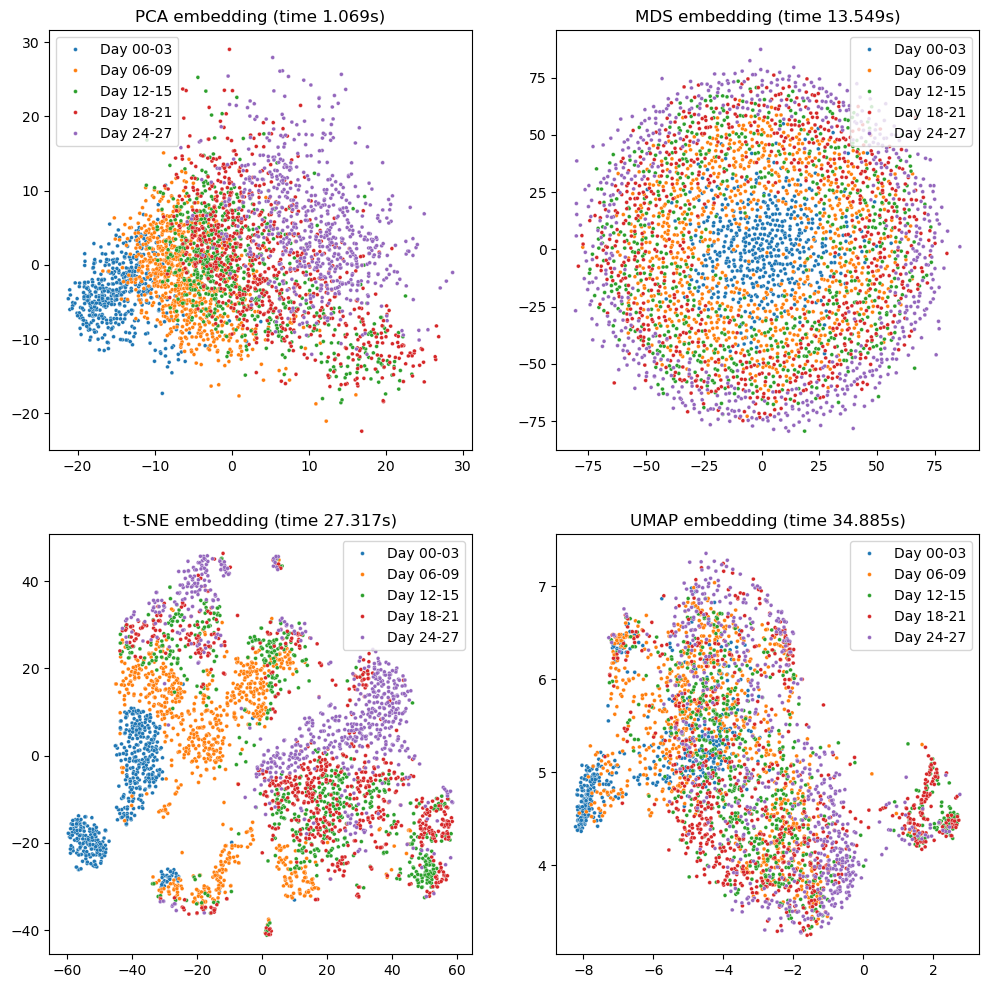

In [57]:
fig_CELLS, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

coords = {"PCA embedding": (0,0),
    "MDS embedding": (0,1),
    "t-SNE embedding": (1,0),
    "UMAP embedding": (1,1)
         }

for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    sns.scatterplot(x=projections[name][:,0], y=projections[name][:, 1], hue=y, ax=axs[*coords[name]], s=8)
    axs[*coords[name]].set_title(title)


plt.show()